In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Hyperleda Query Hubble Plots

In [5]:
%load_ext autoreload
%autoreload 2

In [10]:
plt.rcParams.update({'font.size': 25})
plt.style.use("dark_background")

In [11]:
df = pd.read_csv('hyperleda_new.csv').dropna()
df

,Objectname,distance_modulus,v_gsr,distance_mpc
0,PGC3116657,37.250,25977.0,281.838293
1,PGC3116670,37.590,22950.3,329.609712
2,UGC00866,31.863,1803.2,23.583052
3,NGC0497,35.255,8193.1,112.460497
4,PGC1183727,37.570,28268.3,326.587832
...,...,...,...,...
4232,ESO576-050,31.002,1858.6,15.863536
4233,NGC4628,33.160,2709.0,42.854852
4234,ESO373-008,29.930,702.7,9.682779
4235,NGC1494,30.466,970.7,12.393672


In [12]:
distance_mpc = df['distance_mpc']
vel_gsr =  df['v_gsr']


Text(0, 0.5, 'Vel(km/s)')

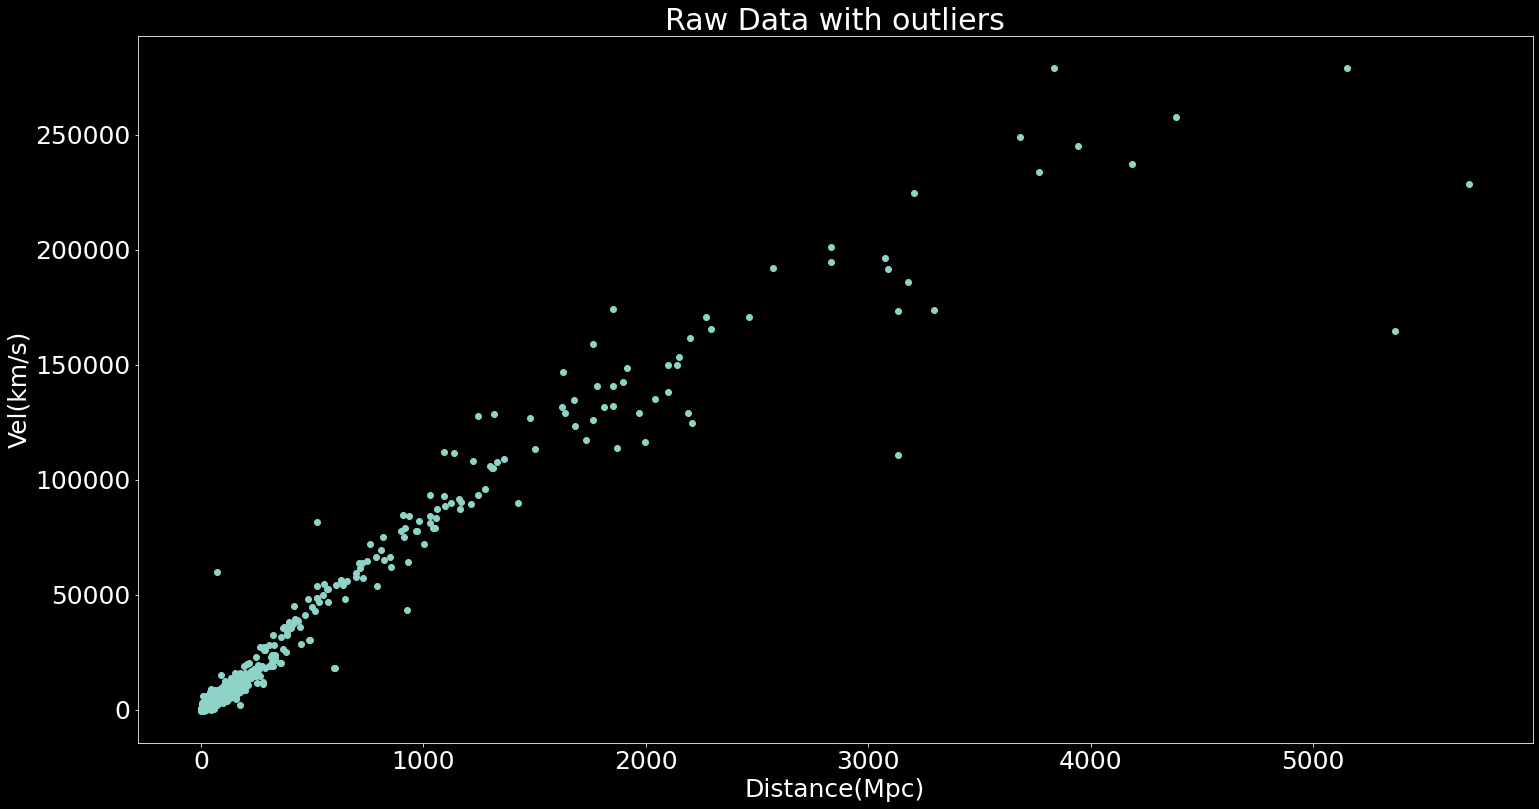

In [13]:
plt.figure(figsize = (25,13))
plt.scatter(distance_mpc,vel_gsr)
plt.title('Raw Data with outliers')
plt.xlabel('Distance(Mpc)')
plt.ylabel('Vel(km/s)')

In [167]:
df_filtered = df.where(df.where(df['distance_mpc']<120).dropna()['v_gsr']<15000).dropna()
distance_mpc_filtered = df_filtered['distance_mpc']
vel_gsr_filtered =  df_filtered['v_gsr']
df_filtered

,Objectname,distance_modulus,v_gsr,distance_mpc
2,UGC00866,31.863,1803.2,23.583052
3,NGC0497,35.255,8193.1,112.460497
5,NGC2410,33.970,4648.6,62.230029
7,PGC090801,33.970,3863.3,62.230029
8,PGC090803,34.521,5284.5,80.204733
...,...,...,...,...
4232,ESO576-050,31.002,1858.6,15.863536
4233,NGC4628,33.160,2709.0,42.854852
4234,ESO373-008,29.930,702.7,9.682779
4235,NGC1494,30.466,970.7,12.393672


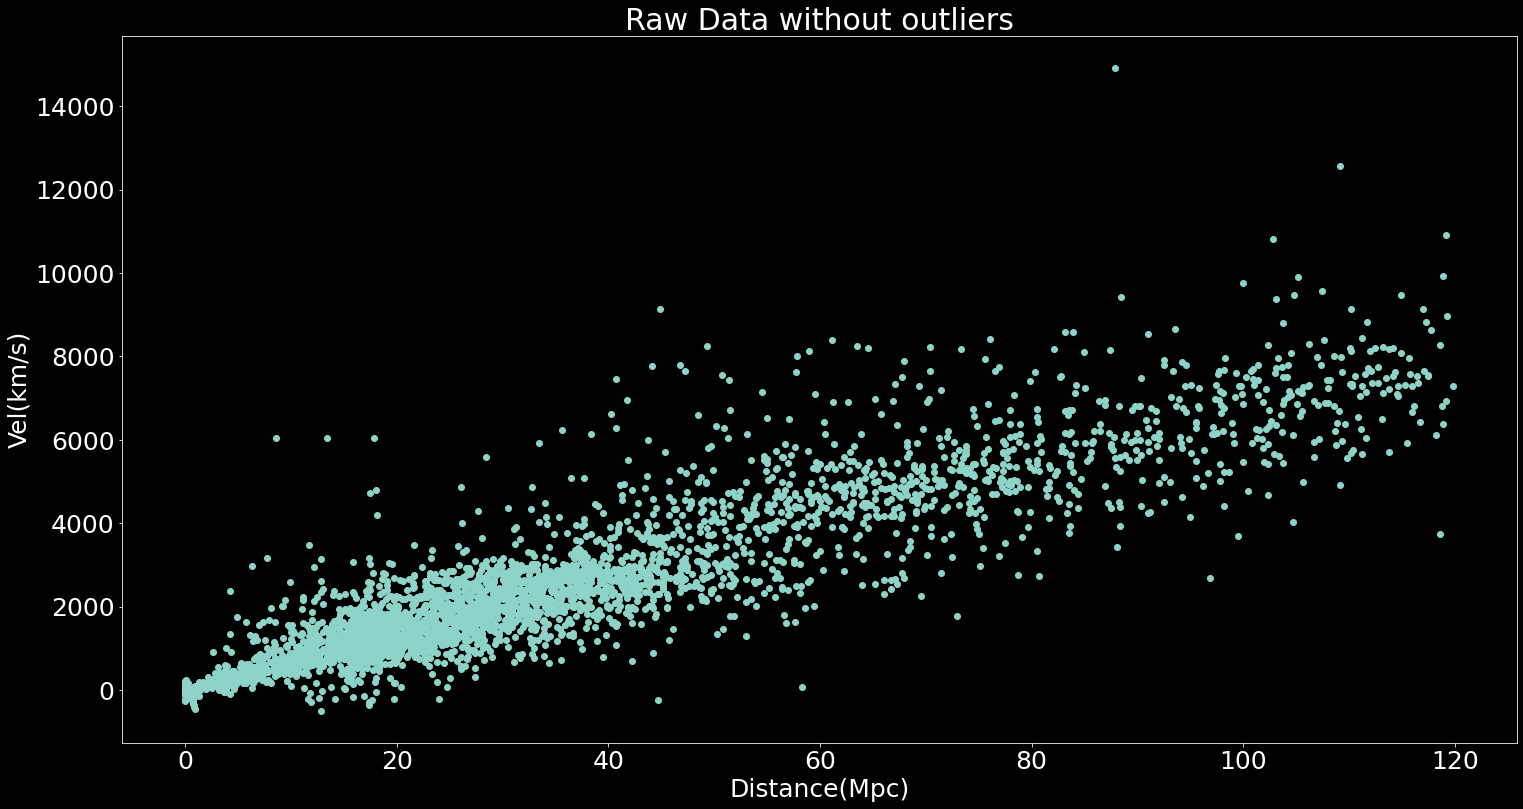

In [168]:
plt.figure(figsize = (25,13))
plt.scatter(distance_mpc_filtered,vel_gsr_filtered)
#plt.ylim(-1000, 20000)
plt.title('Raw Data without outliers')
plt.xlabel('Distance(Mpc)')
plt.ylabel('Vel(km/s)')
plt.show()


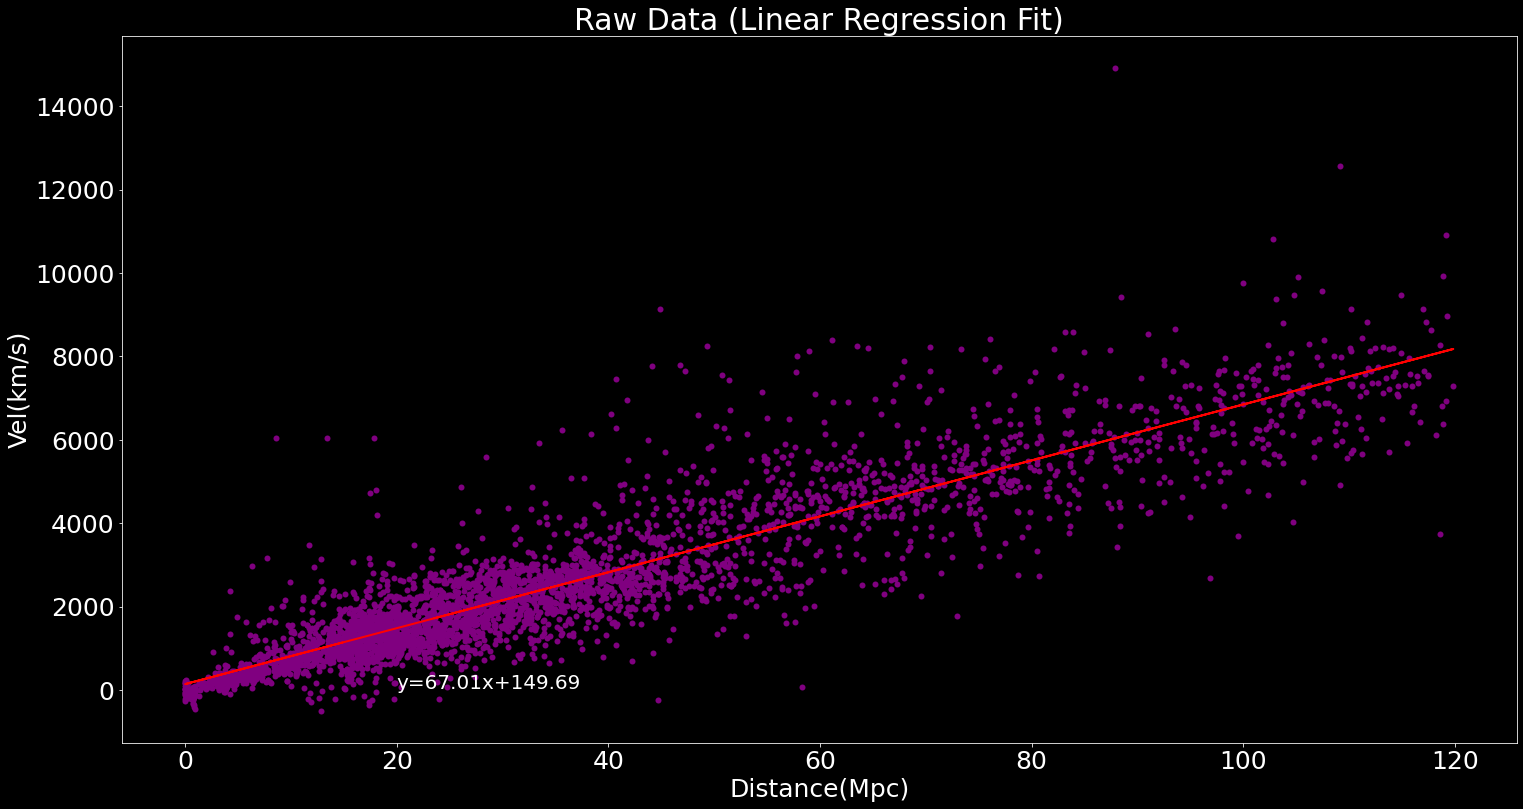

In [169]:
from sklearn.linear_model import LinearRegression as lgr
model = lgr().fit(np.array(distance_mpc_filtered).reshape(-1, 1), vel_gsr_filtered)
predicted_vel_gsr = model.coef_ * distance_mpc_filtered + model.intercept_
plt.figure(figsize = (25,13))
plt.scatter(distance_mpc_filtered,vel_gsr_filtered, linewidth = .01, c='purple')
plt.plot(distance_mpc_filtered,predicted_vel_gsr, linewidth = 2, c='red')
plt.text(20, 30, 'y={:.2f}x+{:.2f}'.format(float(model.coef_), model.intercept_),  fontsize = 20)
#plt.ylim(-1000, 20000)
plt.title('Raw Data (Linear Regression Fit)')
plt.xlabel('Distance(Mpc)')
plt.ylabel('Vel(km/s)')
plt.show()


# Hyperleda Query Trying Eli's Cosmo Fit

In [170]:
df_filtered

,Objectname,distance_modulus,v_gsr,distance_mpc
2,UGC00866,31.863,1803.2,23.583052
3,NGC0497,35.255,8193.1,112.460497
5,NGC2410,33.970,4648.6,62.230029
7,PGC090801,33.970,3863.3,62.230029
8,PGC090803,34.521,5284.5,80.204733
...,...,...,...,...
4232,ESO576-050,31.002,1858.6,15.863536
4233,NGC4628,33.160,2709.0,42.854852
4234,ESO373-008,29.930,702.7,9.682779
4235,NGC1494,30.466,970.7,12.393672


In [119]:
# packages
import scipy.integrate as integrate
import scipy.optimize as opt
import matplotlib.pyplot as plt
import astropy
# constant
c = 2.99792458 * 1e5 # units: km/s

In [208]:
df_new_filtered = df.where(df['distance_mpc']<500).dropna()

In [209]:
redshift = (df_new_filtered['v_gsr']/c).to_numpy()
dist_modulus = df_new_filtered['distance_modulus'].to_numpy()
lum_dist = 10**((dist_modulus - 25)/5)

In [210]:
print(redshift)
print(lum_dist)

[0.08664995 0.07655396 0.00601483 ... 0.00234395 0.00323791 0.00348741]
[281.83829313 329.60971218  23.58305153 ...   9.68277856  12.39367205
  14.82518085]


In [211]:
def D_L(z, omega_m, omega_lambda, H_0):
    omega_k = 1-omega_m-omega_lambda
    if (omega_k == 0): # handle this case separately to avoid division by zero errors
        def integrand(x):
            return 1/np.sqrt((1+x)**2*(1+omega_m*x) - x*(2+x)*omega_lambda)
        integral = integrate.quad(integrand,0,z)[0]
        r = c*integral/H_0
        return (1+z)*r
        
    prefactor = (c/H_0) * (1+z) * (1/np.sqrt(np.abs(omega_k)))
    def integrand(x):
        return 1/np.sqrt((1+x)**2 * (1+omega_m*x) - x * (2+x) * omega_lambda)
    integral = integrate.quad(integrand,0,z)[0]
    arg = np.sqrt(np.abs(omega_k)) * integral
    sinn = np.sin(arg) if omega_k <= 0 else np.sinh(arg)
    return prefactor * sinn

In [212]:
def D_L_helper(redshifts, omega_m, omega_lambda, H_0):
    return [D_L(z,omega_m,omega_lambda,H_0) for z in redshifts]

In [213]:
bnds = ((0,0,60),(2,2,70))
popt, pcov = opt.curve_fit(D_L_helper, redshift, lum_dist, p0=[0.3,0.7,67], bounds=bnds, check_finite=True)

omega_m, omega_lambda, H_0 = popt
omega_m_err, omega_lambda_err, H_0_err = np.sqrt(np.diag(pcov))

In [214]:
print("Matter density: ", omega_m)
print("Dark energy density: ", omega_lambda)
print("Hubble constant: ",H_0)

Matter density:  1.9999999999999998
Dark energy density:  5.813084456137427e-25
Hubble constant:  69.99999999999999


<ipython-input-215-773a2d2a2444>:3: RuntimeWarning: invalid value encountered in log
  plt.scatter(np.log(redshift),lum_dist, color = 'crimson')
<ipython-input-215-773a2d2a2444>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(zz),D_L_helper(zz, 0.3, 0.7, H_0), color = 'lavender')


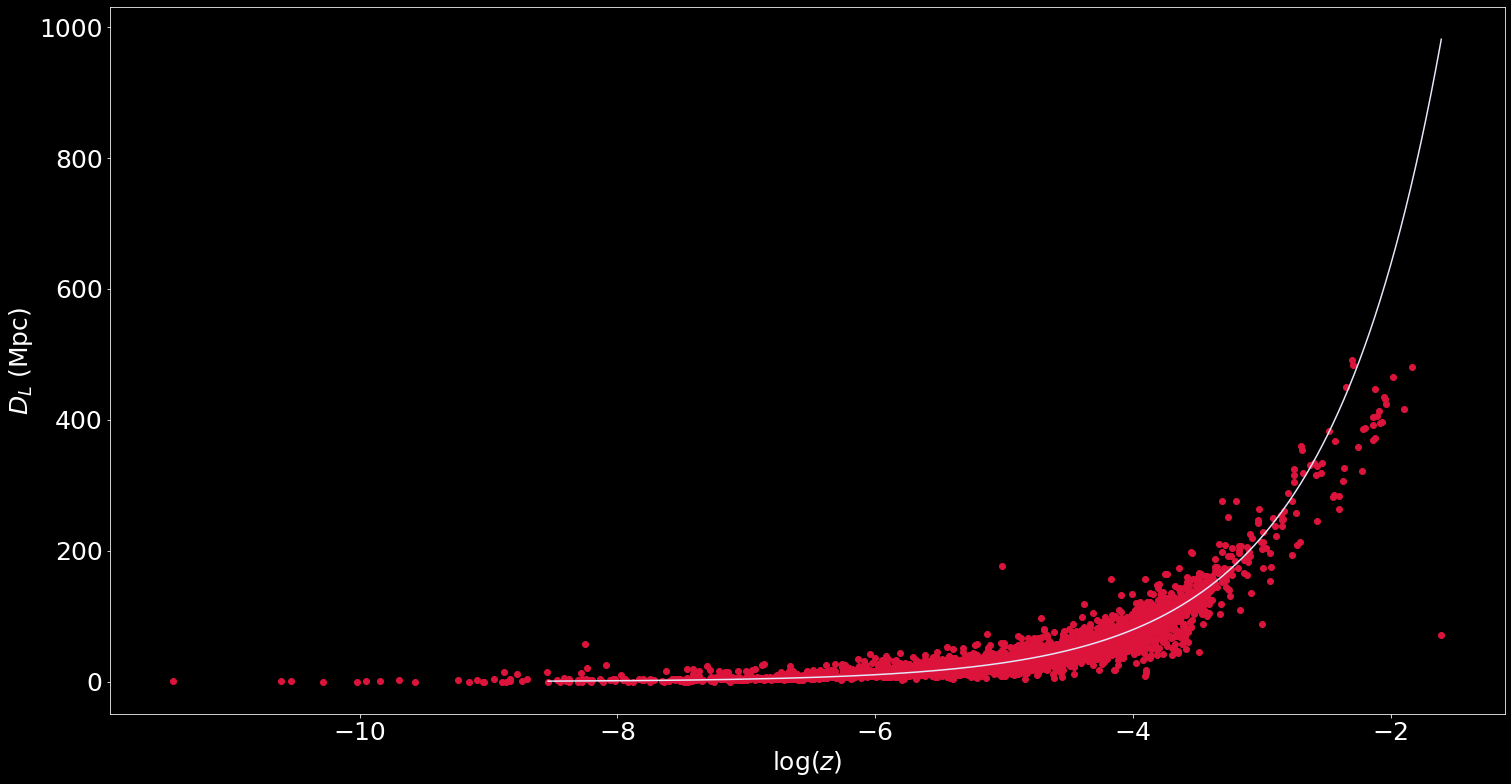

In [215]:
zz = np.linspace(np.min(redshift),np.max(redshift),1000)
plt.figure(figsize=(25,13))
plt.scatter(np.log(redshift),lum_dist, color = 'crimson')
plt.plot(np.log(zz),D_L_helper(zz, 0.3, 0.7, H_0), color = 'lavender')
plt.xlabel("$\log(z)$")
plt.ylabel("$D_L$ (Mpc)");

# Random Simulation

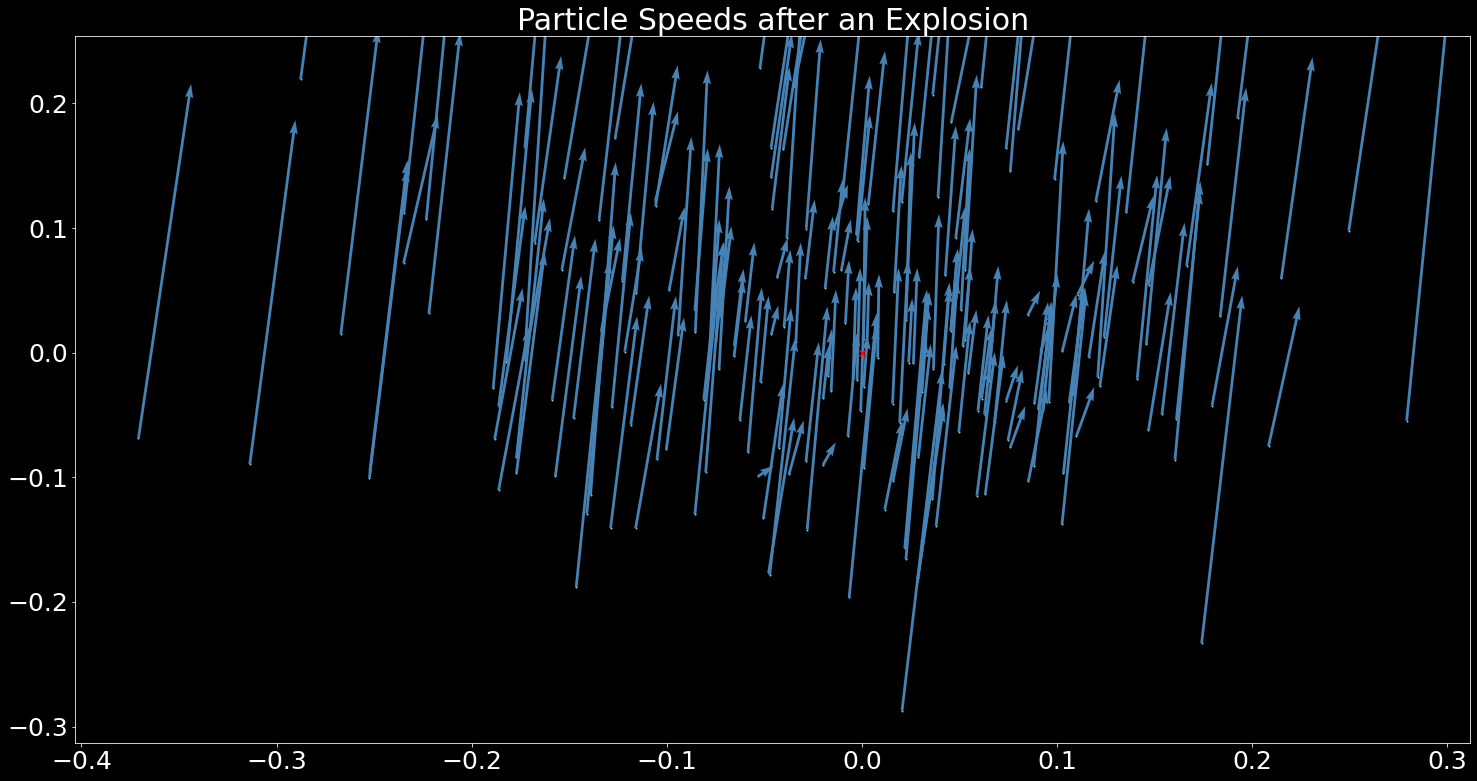

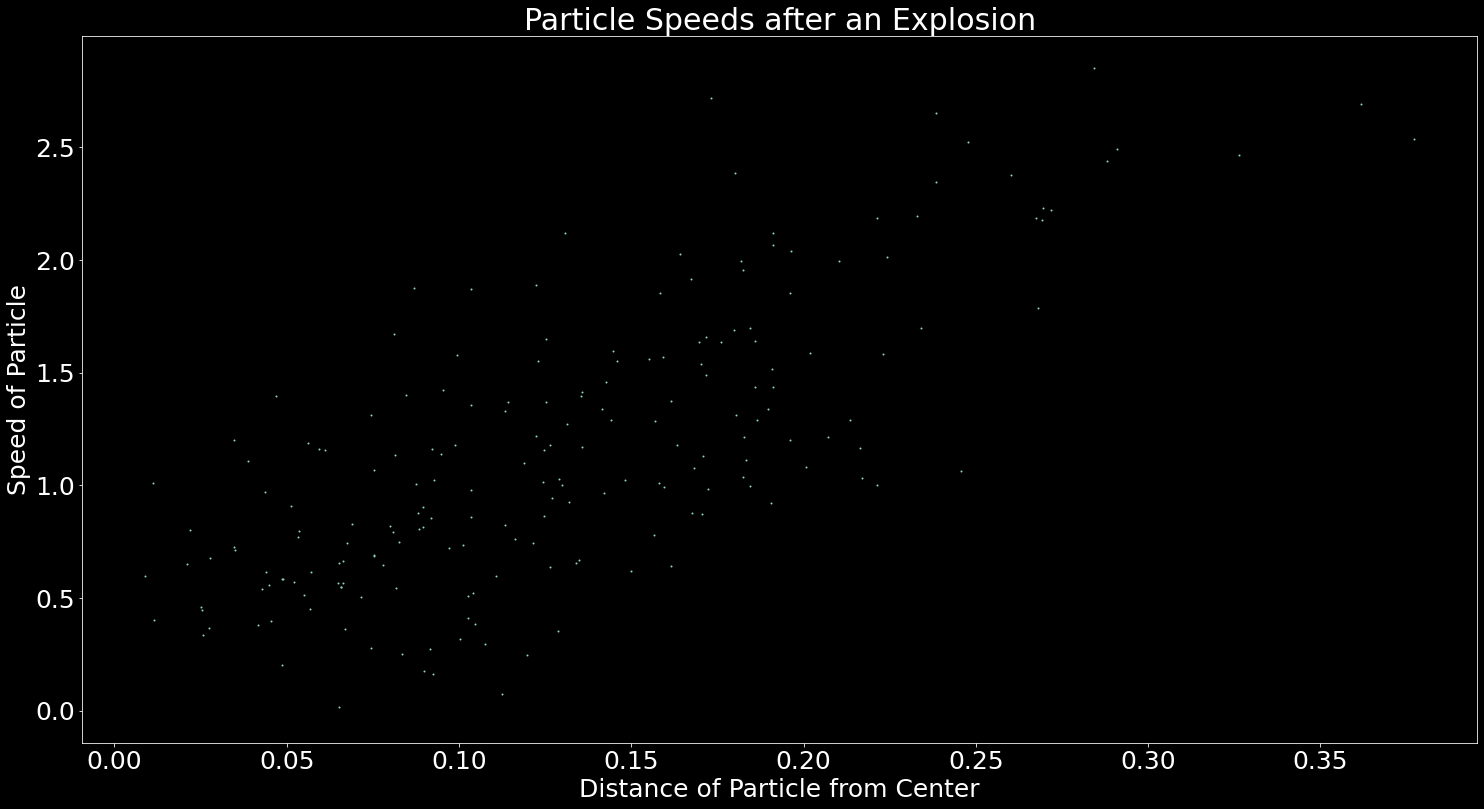

In [30]:
import numpy as np
import matplotlib.pyplot as plt

sim_particles = 500

# Simulates a vector explosion
bigbang = np.column_stack((np.random.normal(0, 1, n), np.random.normal(0, 1, n)))
bigbang_dx = bigbang[:, 0] * 0.1 + 0.05 * np.random.normal(0, 1, n)
bigbang_dy = bigbang[:, 1] * 0.1 + 0.05 * np.random.normal(0, 1, n)
bigbang_speed= np.sqrt(bigbang_dx** 2 + bigbang_dy ** 2)
bigbang_distance = np.sqrt(bigbang[:, 0] ** 2 + bigbang[:, 1] ** 2)

# Plot 1: Particle Speeds after an Explosion
fig, ax = plt.subplots(figsize=(25, 13))
ax.scatter(bigbang_dx, bigbang_dy, s=1)
ax.quiver(bigbang_dx, bigbang_dy, bigbang_speed, bigbang_distance, color='steelblue', scale=10, width=0.002)
ax.scatter(0, 0, color='red', marker='x')
ax.set_title('Particle Speeds after an Explosion')

# Plot 2: Particle Speeds vs. Distance from Center
fig, ax = plt.subplots(figsize=(25, 13))
ax.scatter(bigbang_speed, bigbang_distance, s=1)
ax.plot(bigbang_speed, bigbang_distance * 0, linestyle='--', color='black', linewidth=1)
ax.set_xlabel('Distance of Particle from Center')
ax.set_ylabel('Speed of Particle')
ax.set_title('Particle Speeds after an Explosion')
plt.show()

